In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Critical Core Mass 

In this notebook, we take a numerical look at the planet model discussed on Exercise sheet 8 (questions 4 and 5). A quick recap: we are looking for hydrostatic solutions for a planetary envelope in the presence of a central core for a particularly simple equation of state, \\(P=K\rho^2\\). While this is a vast oversimplification of real giant planet models, it serves to illustrate the basic physical processes.  

The equation for hydrostatic equilibrium, using the equation of state, is:
\\[ \frac{d}{dr} \left(r^2 \frac{d\rho}{dr}\right) = -\frac{2\pi G}{K} r^2 \rho,\\]
with boundary conditions at the core surface \\(\rho(r_c)=\rho_i\\) and \\( d\rho/dr = -GM_c\rho_i/(2K r_c^2)\\). Here \\(r_c\\) is the core radius, \\(M_c\\) the core mass, and \\(\rho_i\\) the gas density at the core surface. In question 4 of Exercise sheet 8 you saw how to solve this differential equation. In this notebook, we take a more visual approach to see what is going on. First of all, from the differential equation and the boundary conditions, can you identify all parameters that specify a particular model? Hint: there are 4...

## Disc conditions

As you have hopefully seen, a planet model is completely specified by the core mass \\(M_c\\), core density \\(\rho_c\\) (i.e. the density of solid rock), which determines the core radius \\(r_c\\), the gas density at the surface of the core \\(\rho_i\\), and the equation-of-state parameter \\(K\\). If we know all these quantities, we can solve the differential equation to determine \\(\rho(r)\\).

The equation of state parameter \\(K\\) is related to the sound speed \\(c_s\\):
\\[ c_s^2 = \frac{dP}{d\rho} = 2 K\rho. \\]
We take a simple, Minimum-Mass Solar Nebula type of disc that has a mid plane density profile
\\[ \rho(r) = 1.0\cdot 10^{-6} \left(\frac{r}{\mathrm{AU}}\right)^{-5/2}~\mathrm{kg~m^{-3}},\\]
and a sound speed such that the aspect ratio of the disc \\(H/r = 0.05\\) everywhere:
\\[ c_s = 1500 \left(\frac{r}{\mathrm{AU}}\right)^{-3/2}~\mathrm{m~s^{-1}}.\\]
Therefore, if we pick a radial location in the disc (say 1 AU), we have an ambient density for our outer boundary condition: the planet density should match the disc density at the outer boundary. We also have a sound speed and can therefore calculate \\(K\\). **The disc model specifies \\(K\\) and the density at the outer boundary.**

## Arbitrary outer density

We first of all forget about matching the density at the planet radius to the density of the disc. Therefore, having specified \\(K\\) using our disc model, and setting \\(\rho_c = 3000~\mathrm{kg~m^{-3}}\\), a planet model is then specified by choosing a core mass and the gas density at the core surface. We focus on an orbital distance of \\(0.01\\) AU, purely because this case roughly corresponds to the figure accompanying question 5 on Exercise sheet 8.

In the figure below, you can change the core mass and central density and look at the resulting density profile. The title of the plot gives \\( \xi_c\\) and \\( \rho_i/\rho_c\\), which you can compare to the figure on Exercise sheet 8, as well as the total mass of the planet (i.e. core + envelope). You will see that some combinations do not yield a solution, as predicted by question 5 on Exercise sheet 8.

FloatLogSlider(value=1000000000000.0, description='$M_c/M_\\oplus$', max=12.972542377191184, min=9.97254237719…

Output()

FloatLogSlider(value=111.3294123680041, description='$\\rho_i$', max=3.1760912590556813, min=1.477121254719662…

Output()

<IPython.core.display.Javascript object>


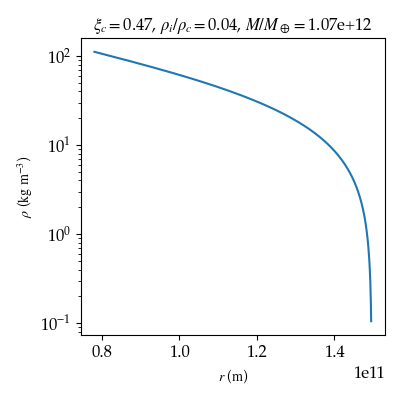

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, bisect
from scipy.integrate import quad
from IPython.display import display, update_display, HTML
import ipywidgets as widgets
import warnings

# Try and make plots look nice
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.serif"] = 'Palatino'
plt.rcParams['pdf.fonttype'] = 42
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

class PlanetModel():
    def __init__(self, semi_major=1):
        self.rho_c = 3000.0            # core density kg/m^3
        self.rho_d = 1.0e-6*np.power(semi_major, -2.5)            # disc density ~ 1 AU
        self.au = 1.495978707e11*semi_major       # AU in m
        self.Mstar = 2.0e30            # Solar mass in kg
        self.G = 6.67408e-11           # Gravitational constant in SI
        cs = 0.05*30000.0*np.power(semi_major, -1.5)              # sound speed at ~ 1 AU
        self.K = 0.5*cs*cs/self.rho_d  # K based on sound speed 
        self.alpha = np.sqrt(2*self.K/(4*np.pi*self.G))
        
    def mass(self, M_c):
        rho_i = self.central_dens(M_c)
        M, R, d = self.mass_density(M_c, rho_i)

        r_c = np.power(M_c/(4*np.pi*self.rho_c/3), 1/3)
        xi_c = r_c/self.alpha
        c1, c2 = self.c1c2(xi_c, rho_i)

        m = lambda x: 4.0*np.pi*rho_i*self.alpha**3*(np.sin(x)*(c1 + c2*x) + np.cos(x)*(c2 - c1*x))
        
        return m(R/self.alpha)
               
    def central_dens(self, M_c):
        f = lambda x: self.mass_density(M_c, x)[2] - self.rho_d
        
        warnings.simplefilter("error")
        try:
            res = fsolve(f, self.rho_d)
        except RuntimeWarning:
            warnings.simplefilter("default")
            return -1.0, -1.0
        warnings.simplefilter("default")
        
        if (f(1.001*res[0])*f(self.rho_c) < 0.0):
            res1 = bisect(f, 1.001*res[0], self.rho_c)    
        else:
            res1 = res[0]

        return res[0], res1
    
    def mass_density(self, M_c, rho_i, demand_physical=False):
        r_c = np.power(M_c/(4*np.pi*self.rho_c/3), 1/3)
        xi_c = r_c/self.alpha
        
        a = 4.0*np.pi*rho_i*self.au**3/self.Mstar/3.0
        c1, c2 = self.c1c2(xi_c, rho_i)
        func = lambda x: a*(np.sin(x)*(c1 + c2*x) + np.cos(x)*(c2 - c1*x)) - x**3
        
        n = np.ceil((xi_c + np.arctan2(c2, c1))/np.pi)
        xi_n = n*np.pi - np.arctan2(c2, c1)
        
        if (func(xi_c)*func(xi_n) < 0.0):
            xi_out = bisect(func, xi_c, xi_n)
        else:
            if (demand_physical == True):
                return 0.0, xi_c*self.alpha, rho_i
        
            if (func(xi_c)*func(xi_n + np.pi) < 0.0):
                xi_out = bisect(func, xi_c, xi_n + np.pi)
            else:
                print('Going to use fsolve...')
                fprime = lambda x: a*(np.cos(x)*(c1 + c2*x) + c2*np.sin(x) - np.sin(x)*(c2 - c1*x) - c1*np.cos(x)) - 3*x**2
        
                n = np.ceil((xi_c + np.arctan2(c2, c1))/np.pi) + 1
                xi_n = n*np.pi - np.arctan2(c2, c1)
        
                res = fsolve(func, xi_n, fprime=fprime)
                res1 = fsolve(func, xi_c, fprime=fprime)
        
                xi_out = res[0]
                if (np.abs(func(res1[0])) < np.abs(func(res[0]))):
                    xi_out = res1[0]
            
                if (np.min([np.abs(func(res[0])), np.abs(func(res1[0]))]) > 1.0e-10):
                    print('Warning: no accurate outer boundary found')
                                   
        mass = 3*self.Mstar*(self.alpha*xi_out/self.au)**3
        dens = rho_i*self.theta(xi_out, xi_c, rho_i)
        radius = xi_out*self.alpha
    
        return mass, radius, dens
        
    def density(self, M_c, rho_i, demand_physical=False):
        m, r, d = self.mass_density(M_c, rho_i, demand_physical)
        
        r_c = np.power(M_c/(4*np.pi*self.rho_c/3), 1/3)
        xi_c = r_c/self.alpha
        xi_out = r/self.alpha
        xi = np.linspace(xi_c, xi_out, 1000)
        r = self.alpha*xi
    
        return r, rho_i*self.theta(xi, xi_c, rho_i)

    def c1c2(self, xi_c, rho_i):
        c1 = xi_c*np.sin(xi_c) + np.cos(xi_c) - self.rho_c*xi_c*xi_c*np.cos(xi_c)/(3*rho_i)
        c2 = xi_c*np.cos(xi_c) - np.sin(xi_c) + self.rho_c*xi_c*xi_c*np.sin(xi_c)/(3*rho_i)
           
        return c1, c2

    def theta(self, xi, xi_c, rho_i):
        c1, c2 = self.c1c2(xi_c, rho_i)
        
        return (c1*np.sin(xi) + c2*np.cos(xi))/xi
 
M_earth = 5.972e24

p = PlanetModel(semi_major=0.0098)
# semi_major = 0.0098 leads to A = 0.05

w_m = widgets.FloatLogSlider(
    value=1.0e12,
    base=10,
    min=np.log10(0.001*4*np.pi*p.rho_c*p.alpha**3/3/M_earth), # max exponent of base
    max=np.log10(4*np.pi*p.rho_c*p.alpha**3/3/M_earth), # min exponent of base
    step=0.2, # exponent step
    description=r'$M_c/M_\oplus$'
)

w_d = widgets.FloatLogSlider(
    value=111.3294123680041,
    base=10,
    min=np.log10(0.01*p.rho_c), # max exponent of base
    max=np.log10(0.5*p.rho_c), # min exponent of base
    step=0.01, # exponent step
    description=r'$\rho_i$'
)


# Display eccentricity slider
output = widgets.Output()
display(w_m, output)
display(w_d, output)

M_c = 1.0e12*M_earth
rho_i = 111.3294123680041 

fig = plt.figure(figsize=(4,4),num='Density profile')
ax = plt.gca()

ax.set_xlabel(r'$r$ ($\mathrm{m}$)')
ax.set_ylabel(r'$\rho$ ($\mathrm{kg~m^{-3}}$)')

#ax.set_xscale('log')
ax.set_yscale('log')

r, dens = p.density(M_c, rho_i, demand_physical=True)
M0, R0, D0 = p.mass_density(M_c, rho_i, demand_physical=True)
rc = np.power(M_c/(4*np.pi*p.rho_c/3), 1/3)
#print(M_c, rho_i)
ax.set_title(r'$\xi_c = ${:.2f}, $\rho_i/\rho_c=${:.2f}, $M/M_\oplus=${:.2e}'.format(rc/p.alpha, rho_i/p.rho_c,M0/M_earth))
line, = ax.plot(r, dens)

plt.tight_layout()

def on_value_change_m(change):
    with output:
        global M_c, rho_i
        M_c = change['new']*M_earth
        r, dens = p.density(M_c, rho_i, demand_physical=True)
        M0, R0, D0 = p.mass_density(M_c, rho_i, demand_physical=True)
        rc = np.power(M_c/(4*np.pi*p.rho_c/3), 1/3)
        #ax.set_title(r'$\xi_c = ${:.2f}, $\rho_i/\rho_c=${:.2f}'.format(rc/p.alpha, rho_i/p.rho_c))
        ax.set_title(r'$\xi_c = ${:.2f}, $\rho_i/\rho_c=${:.2f}, $M/M_\oplus=${:.2e}'.format(rc/p.alpha, rho_i/p.rho_c,M0/M_earth))
        line.set_data(r, dens)

        ax.relim()
        ax.autoscale()
        plt.tight_layout()

def on_value_change_d(change):
    with output:
        global rho_i, M_c
        #print(M_c, rho_i)

        rho_i = change['new']
        r, dens = p.density(M_c, rho_i, demand_physical=True)
        M0, R0, D0 = p.mass_density(M_c, rho_i, demand_physical=True)
        rc = np.power(M_c/(4*np.pi*p.rho_c/3), 1/3)
        #ax.set_title(r'$\xi_c = ${:.2f}, $\rho_i/\rho_c=${:.2f}'.format(rc/p.alpha, rho_i/p.rho_c))
        ax.set_title(r'$\xi_c = ${:.2f}, $\rho_i/\rho_c=${:.2f}, $M/M_\oplus=${:.2e}'.format(rc/p.alpha, rho_i/p.rho_c,M0/M_earth))
        line.set_data(r, dens)

        ax.relim()
        ax.autoscale()
        plt.tight_layout()
 
w_d.observe(on_value_change_d, names='value')
w_m.observe(on_value_change_m, names='value')


As you change the values of \\(M_c\\) and \\(\rho_i\\), you will notice that the density profiles change character. Note also that the outer density (the density at the largest radius that is shown, which equals the planet radius) changes considerably between models. 

1. Can you verify (by eye) that the inner boundary conditions are satisfied? 
2. For \\(\rho_i \sim \rho_c\\), the solution should approach a sinc function for small core masses (this can be seen from the solution of question 4 by letting \\(\xi_c\rightarrow 0\\) yielding \\( c_1\approx 1\\) and \\(c_2 \approx 0\\) ). Can you verify that this is indeed the case? How does this limit relate to the water worlds we studied in Exercise sheet 3?
3. Can you spot the difference between a model where the mass of the envelope is negligible and a model where the envelope mass is much larger than the core mass?
4. How does the radius of the planet vary with core mass and central density? For example: choose a central density so that the total mass of the planet is much larger than the core mass. Now vary the core mass, and monitor the radius of the planet. Again, how does this compare with the water worlds of Exercise sheet 3?

Finally, the values of the core masses are huge and not a typo! Here we really hit the limits of the simple equation of state we have used. Also, extrapolating the MMSN to about 2 Solar radii (=0.01 AU) might be problematic. The reason for this choice is, as we will see below, that if we go further out the allowed range of \\(\rho_i\\) gets incredibly small, which makes visualisation as done above much more problematic. However, it is usually found that the critical core mass goes up for smaller orbital radii.   

## Connecting to the disc at the outer boundary

We now consider only models that can connect to the disc density at their outer boundary. We consider our MMSN disc at 10 AU, with a density \\(\rho(10~\mathrm{AU}) = 3\cdot 10^{-9}~\mathrm{kg~m^{-3}}\\). As you have seen in question 5 of Exercise sheet 8, there are either zero, one, or two solutions for a given core mass that can connect to the disc. For small core masses, there are two solutions: one high mass and one low mass solution. At the critical core mass, they come together at a single point, while beyond the critical core mass no more static solutions exist that can connect to the disc. In the figure below, the two density profiles are shown, with the total masses in the figure title. The slider changes the core mass. 

FloatLogSlider(value=10.0, description='$M_c/M_\\oplus$', max=1.6020599913279623, min=-1.0, step=0.02)

Output()

<IPython.core.display.Javascript object>


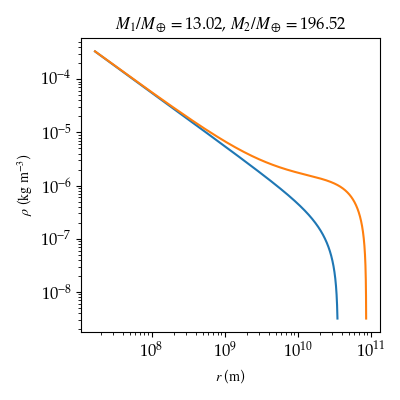

In [3]:
p2 = PlanetModel(semi_major=10)

w2_m = widgets.FloatLogSlider(
    value=10,
    base=10,
    min=np.log10(0.1), # max exponent of base
    max=np.log10(40), # min exponent of base
    step=0.02, # exponent step
    description=r'$M_c/M_\oplus$'
)

# Display eccentricity slider
#output = widgets.Output()
display(w2_m, output)

M_c2 = 10*M_earth

fig2 = plt.figure(figsize=(4,4),num='')
ax2 = plt.gca()

ax2.set_xlabel(r'$r$ ($\mathrm{m}$)')
ax2.set_ylabel(r'$\rho$ ($\mathrm{kg~m^{-3}}$)')

ax2.set_xscale('log')
ax2.set_yscale('log')

rho1, rho2 = p2.central_dens(M_c2)

M1, R1, D1 = p2.mass_density(M_c2, rho1, demand_physical=True)
M2, R2, D2 = p2.mass_density(M_c2, rho2, demand_physical=True)

r1, dens1 = p2.density(M_c2, rho1, demand_physical=True)
r2, dens2 = p2.density(M_c2, rho2, demand_physical=True)
rc = np.power(M_c2/(4*np.pi*p2.rho_c/3), 1/3)
ax2.set_title(r'$M_1/M_\oplus = ${:.2f}, $M_2/M_\oplus=${:.2f}'.format(M1/M_earth, M2/M_earth))
line1, = ax2.plot(r1, dens1)
line2, = ax2.plot(r2, dens2)

plt.tight_layout()

def on_value_change_m2(change):
    with output:
        global M_c2
        M_c2 = change['new']*M_earth
        rho1, rho2 = p2.central_dens(M_c2)
        r1, dens1 = p2.density(M_c2, rho1, demand_physical=True)
        r2, dens2 = p2.density(M_c2, rho2, demand_physical=True)
        rc = np.power(M_c2/(4*np.pi*p2.rho_c/3), 1/3)
        
        M1, R1, D1 = p2.mass_density(M_c2, rho1, demand_physical=True)
        M2, R2, D2 = p2.mass_density(M_c2, rho2, demand_physical=True)

        ax2.set_title(r'$M_1/M_\oplus = ${:.2f}, $M_2/M_\oplus=${:.2f}'.format(M1/M_earth, M2/M_earth))

        if (rho1 < 0.0):
            dens1[0] = p2.rho_d
            dens2[0] = p2.rho_d
            
        line1.set_data(r1, dens1)
        line2.set_data(r2, dens2)

        ax2.relim()
        ax2.autoscale()
        plt.tight_layout()
 
w2_m.observe(on_value_change_m2, names='value')



1. For small core masses, how do the two solutions differ? Note that the difference in \\(\rho_i\\) for the two solutions is always tiny, and is only really visible towards very small cores. This was the reason for considering a
2. Can you find the critical core mass? 
3. How does the radius of the planet depend on core mass?  
4. How does the planet radius at the critical core mass compare to the local scale height? Can you comment on the use of a single value for the disc density to match the planet model to?

